In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter
import seaborn as sns

In [3]:
import matplotlib as mpl

# Set Helvetica font globally
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica']

# Optional: make sure fonts are updated
mpl.rcParams['pdf.fonttype'] = 42  # Avoids Type 3 fonts in PDF output
mpl.rcParams['ps.fonttype'] = 42

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


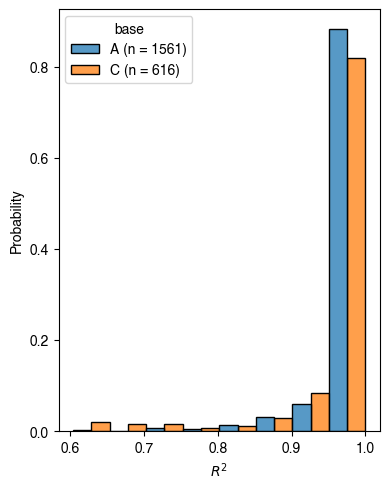

In [5]:
db_path = '/Users/edricchoi/LucksLab Dropbox/LucksLab/Lucks_Lab_Papers/In_Progress/88_EKC_Probing_model/Manuscript/Data_elements/data/new.db'
global_refit_path = '/Users/edricchoi/LucksLab Dropbox/LucksLab/Lucks_Lab_Papers/In_Progress/88_EKC_Probing_model/Manuscript/Data_elements/02_representative_timecourses/global_refit_results.db'


# Connect to new.db
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Attach the global_refit DB
cursor.execute("""
    ATTACH DATABASE ? AS global
""", (global_refit_path,))

# Execute the join with base from nucleotides table
cursor.execute("""
    SELECT 
        gf.site,
        pr.id AS rxn_id,
        gf.r2,
        c.disp_name AS construct_name,
        nt.base
    FROM global.global_fits gf
    JOIN reaction_groups rg ON rg.id = gf.rg_id
    JOIN probing_reactions pr ON pr.rg_id = rg.id
    JOIN constructs c ON c.id = pr.construct_id
    JOIN nucleotides nt ON nt.construct_id = pr.construct_id AND nt.site = gf.site
    WHERE pr.id = (
        SELECT MIN(pr2.id)
        FROM probing_reactions pr2
        WHERE pr2.rg_id = rg.id
    )
""")

results = cursor.fetchall()

# Convert results to DataFrame
df = pd.DataFrame(results, columns=['site', 'rxn_id', 'r2', 'construct_name', 'base'])

# Close the database connection
conn.close()

# Filter and count
df = df[df['base'].isin(['A', 'C'])].drop_duplicates(subset=['site', 'rxn_id', 'r2', 'construct_name', 'base'])
count_base = df['base'].value_counts()

# change 'A' to 'A (n = count_base['A'])' and 'C' to 'C (n = count_base['C'])'
df['base'] = df['base'].apply(lambda x: f'{x} (n = {count_base[x]})')

# Plot
fig, ax = plt.subplots(1, 1, figsize=(4, 5))
sns.histplot(df, x='r2', hue='base', stat='probability', bins=8, multiple='dodge', ax=ax, common_norm=False)

ax.set_xlabel(r'$R^2$')
ax.set_ylabel('Probability')

plt.tight_layout()
plt.savefig('r2_distribution.pdf')